In [1]:
import sys

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img, ax=None, vmin=None, vmax=None, figsize=(7, 7), external=False, title=""):
    if external:
        cv.imshow("imshow", img)
        
        while 1:
            if cv.waitKey(0) & 0xFF == ord("q"):
                break
        
        cv.destroyAllWindows()
        return
    
    gray = False

    if len(img.shape) == 2:
        gray = True
    if img.shape == 3 and img.shape[-1] == 1:
        gray = True

    # trying to remove as much as possible
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.autoscale(tight=True)
    
    if gray:
        ax.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    else:
        ax.imshow(img[:, :, ::-1], vmin=vmin, vmax=vmax)

## Color Conversion from RGB to CIE L\*a\*b\*

In [3]:
def f(X):
    
    X = X.copy()
    
    mask1 = (X >  0.008856)
    mask2 = (X <= 0.008856)
    
    X[mask1] = X[mask1]**(1/3)
    X[mask2] = (7.787*X[mask2]) + (16/116)
    
    return X

def rgb2lab(img):
    
    img = img.astype('float64')
    img /= 255.
    
    img = img**2.2
    
    
    X = (img[:,:,0] * 0.412453) + (img[:,:,1] * 0.357580) + (img[:,:,2] * 0.180423)
    Y = (img[:,:,0] * 0.212671) + (img[:,:,1] * 0.715160) + (img[:,:,2] * 0.072169)
    Z = (img[:,:,0] * 0.019334) + (img[:,:,1] * 0.119193) + (img[:,:,2] * 0.950227)
    
    Xn = 0.950456
    Zn = 1.088754
    delta = 0

    X /= Xn
    Z /= Zn
    
    mask1 = (Y >  0.008856)
    mask2 = (Y <= 0.008856)
    
    L = Y.copy()
    L[mask1] = (116*(L[mask1]**(1/3)) - 16)
    L[mask2] = 903.3*L[mask2]
    
    a = 500 * (f(X) - f(Y)) + delta
    b = 200 * (f(Y) - f(Z)) + delta
    
    L = L*(255/100)
    a = a + 128
    b = b + 128
    
    return np.round(np.dstack([L,a,b])).astype('uint8')        

## Color Correction

### Contrast Limited Adaptive Histogram Equalization (CLAHE)

In [4]:
def _interpolate(c_sub_bin, map_ul, map_ur, map_dl, map_dr, x_frame_size, y_frame_size):
   
    c_sub_image = np.zeros(c_sub_bin.shape)

    for i in range(x_frame_size):
        i_inv = x_frame_size-i
        for j in range(y_frame_size):
            j_inv = y_frame_size-j
            
            val = c_sub_bin[i,j].astype(int)
            c_sub_image[i,j] = i_inv*(j_inv*map_ul[val] + \
                                          j*map_ur[val])+ \
                                i*(j_inv*map_dl[val] + \
                                   j*map_dr[val])

    return (c_sub_image/(x_frame_size*y_frame_size)).astype('int32')

def generate_histograms(bins, n_bins, grid_x_divs, grid_y_divs, x_frame_size, y_frame_size):
    
    hist = np.zeros((grid_x_divs,grid_y_divs,n_bins))
    
    for i in range(grid_x_divs):
        for j in range(grid_y_divs):

            # gets the current frame (it's binned values)
            c_bin = bins[i*x_frame_size : (i+1)*x_frame_size, 
                         j*y_frame_size : (j+1)*y_frame_size]
            c_bin = c_bin.astype('int32')
            
            # updates the current frame's histogram
            for p in range(x_frame_size):
                for q in range(y_frame_size):
                    hist[i,j,c_bin[p,q]]+=1 
    
    return hist

def clip_histogram(hist, clip_limit, n_bins, grid_x_divs, grid_y_divs):

    for i in range(grid_x_divs):
        for j in range(grid_y_divs):
            
            total_overflow = 0
            for c_bin in range(n_bins):
                overflow = hist[i,j,c_bin] - clip_limit
                if overflow > 0:
                    total_overflow += overflow
            
            # to redistribute intensities across each bin
            inc_bin_val = total_overflow/n_bins
            
            # new upper limit for each bin based on how the redistribution has to be done
            upper = clip_limit - inc_bin_val
            
            # redistributing
            for c_bin in range(n_bins):
                if hist[i,j,c_bin] > clip_limit:
                    hist[i,j,c_bin] = clip_limit
                else:
                    if hist[i,j,c_bin] > upper:
                        total_overflow -= (hist[i,j,c_bin] - upper)
                        hist[i,j,c_bin] = clip_limit
                    else:
                        hist[i,j,c_bin] += inc_bin_val
                        total_overflow -= inc_bin_val
                       
            # if there is still some overflow, then uniformly divide the overflow into each bin
            if total_overflow > 0:
                
                div_uniform = max(1, 1+total_overflow//n_bins)
                
                for c_bin in range(n_bins):
                    hist[i,j,c_bin] += div_uniform
                    total_overflow -= div_uniform
                    if total_overflow <= 0:
                        break
    return hist

def create_eq_mappings(hist, n_bins, frame_size, grid_x_divs, grid_y_divs):
    max_val = 255
    min_val = 0
    
    maps = np.zeros((grid_x_divs,grid_y_divs,n_bins))
    scale = (max_val - min_val)/float(frame_size)

    for i in range(grid_x_divs):
        for j in range(grid_y_divs):
            
            c_sum = 0
            for c_bin in range(n_bins):
                c_sum += hist[i,j,c_bin]
                maps[i,j,c_bin] = np.clip((c_sum * scale) + min_val, \
                                          min_val, \
                                          max_val)
    return maps

def interpolate(res, maps, bins, grid_x_divs, grid_y_divs, x_frame_size, y_frame_size):
    x_offset = 0
    for i in range(grid_x_divs):

        x_up = max(0,i-1)
        x_down = min(i, grid_x_divs-1)
        
        y_offset = 0
        for j in range(grid_y_divs):
      
            y_left = max(0,j-1)
            y_right = min(j, grid_y_divs-1)
                
            map_ul = maps[x_up, y_left]
            map_ur = maps[x_up, y_right]
            map_dl = maps[x_down, y_left]
            map_dr = maps[x_down, y_right]
            
            c_sub_bin = bins[x_offset : x_offset + x_frame_size, \
                             y_offset : y_offset + y_frame_size
                            ]

            c_sub_image = _interpolate(c_sub_bin, map_ul, map_ur, map_dl, map_dr, \
                                      x_frame_size, y_frame_size
                                     )
            
            res[x_offset : x_offset+x_frame_size, y_offset : y_offset+y_frame_size] = c_sub_image
            y_offset += y_frame_size
        x_offset += x_frame_size
    
    return res
    

def clahe(img, clip_limit=3.0, n_bins=256, grid=(7,7)):

    h,w = img.shape
    grid_x_divs, grid_y_divs = list(map(lambda x: int(x), grid))
    
    # find amount of padding needed and apply
    padding_x = grid_x_divs - int(h % grid_x_divs)
    padding_y = grid_y_divs - int(w % grid_y_divs)
    
    if padding_x!=0:
        img = np.append(img,np.zeros((padding_x,img.shape[1])).astype(int),axis=0)
    if padding_y!=0:
        img = np.append(img,np.zeros((img.shape[0],padding_y)).astype(int),axis=1)
    
    # initialize result
    res = np.zeros(img.shape)

    # get size of each cell/frame in the grid
    x_frame_size = int(img.shape[0]/grid_x_divs)
    y_frame_size = int(img.shape[1]/grid_y_divs)
    frame_size = x_frame_size*y_frame_size
    
    # set clip limit
    clip_limit = max(5,clip_limit*x_frame_size*y_frame_size/n_bins)
    
    # generate Look Up Table and put pixel intensities into their bins
    bin_size = 256./n_bins
    LUT = (np.arange(256)/bin_size).astype('int32')
    bins = LUT[img]
    
    # creating separate histograms for each frame/cell
    hist = generate_histograms(bins, n_bins, grid_x_divs, grid_y_divs, x_frame_size, y_frame_size)
    
    # clipping the histogram to limit contrast
    hist = clip_histogram(hist, clip_limit, n_bins, grid_x_divs, grid_y_divs)
    
    # creating the equalization mapping
    maps = create_eq_mappings(hist, n_bins, frame_size, grid_x_divs, grid_y_divs)
    
    # Interpolating the values from surrounding frames
    res = interpolate(res, maps, bins, grid_x_divs, grid_y_divs, x_frame_size, y_frame_size)
    
    # return result without padding
    return res[:h, :w].astype('uint8')

In [5]:
def apply_clahe(img, clip_limit=3.0, n_bins=256, grid=(7,7)):

    img = img[:,:,::-1]
    img_lab = rgb2lab(img)
    
    clahe_L = clahe(img_lab[:,:,0], clip_limit, n_bins, grid)

    img_clahe = np.dstack([clahe_L, img_lab[:,:,1], img_lab[:,:,2]])
    return cv.cvtColor(img_clahe, cv.COLOR_LAB2BGR)

## CLAHE Implemention

The above writen `apply_clahe()` function takes in 4 inputs:
* The input image in **BGR** format
* The clip limit for contrast limiting
* Number of bins to divide the image into
* Grid size to be used while performing adaptive histogram equalization

The `clahe()` function performs the following 4 step process to perform color correction:
* Divides the image into frames/cells using the grid values passed to the function
* Creates a separate histogram for each cell/frame after binning the values based on the value passed to the function
* The histogram equalization mapping for each cell/frame is also generated
* Next, the contrast of the image is limited by clipping bin values if they are above a 'clip limit' 
* Finally, adaptive histogram equalization is performed by interpolating the value for each frame by using neighboring frames

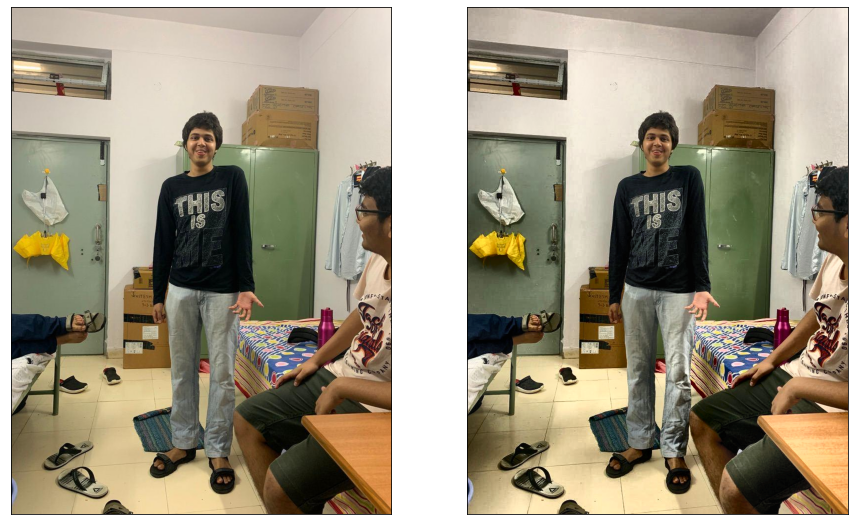

In [6]:
img = cv.imread("images/fullbody.jpg")

clahe_img = apply_clahe(img)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
imshow(img, ax=ax1)
imshow(clahe_img, ax=ax2)

## Face and Body Detection

In [ ]:
def draw_box(img, bounding_box):
    img = img.copy()
    x, y, w, h = bounding_box
    
    return cv.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)

In [ ]:
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml

In [ ]:
def get_face(img):
    img = img.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    face_cascade = cv.CascadeClassifier()

    if not face_cascade.load(cv.samples.findFile("./haarcascade_frontalface_default.xml")):
        print("--(!)Error loading face cascade")
        sys.exit(1)

    try:
        face = face_cascade.detectMultiScale(img_gray)[0]
    except IndexError as e:
        print(e)
        print("--(!)No faces detected")
        sys.exit(1)
    
    return face

In [ ]:
def get_body(img, face_bounds):
    # image height
    hi = img.shape[0]

    # face bounds
    xf, yf, wf, hf = face_bounds
    
    # x_body_left = x_face_left - wf
    x = xf - wf
    # y_body_top = y_face_top - hf
    y = yf - hf
    w = 3 * wf
    h = hi - y
    
    return (x, y, w, h)

In [ ]:
face_bounds = get_face(clahe_img)
body_bounds = get_body(clahe_img, face_bounds)
boxed_face = draw_box(clahe_img, face_bounds)
boxed_body = draw_box(boxed_face, body_bounds)
imshow(boxed_body)

In [ ]:
cv.imwrite("images/outputs/fb-detect.png", boxed_body)
cv.imwrite("images/outputs/col-corr.png", clahe_img)